导入包并定义变换

In [2]:
import torch
from torch.utils.tensorboard.summary import image
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TrainTransforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
TestTransforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

应用预训练模型（可改为resnet50或vgg等）

In [3]:
# 定义模型
myModel = torchvision.models.resnet18(pretrained=True)
# 将原来的ResNet18的最后两层全连接层拿掉,替换成一个输出单元为10的全连接层
inchannel = myModel.fc.in_features
myModel.fc = nn.Linear(inchannel, 200)

# 损失函数及优化器
# GPU加速
myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(myDevice)

In [6]:
train_dir = "/home/featurize/data/CUB_200_2011/train"
test_dir = "/home/featurize/data/CUB_200_2011/test"
train_datasets = datasets.ImageFolder(train_dir,TrainTransforms)
test_datasets = datasets.ImageFolder(test_dir,TestTransforms)

In [5]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=False, num_workers=2)
myLoss = nn.CrossEntropyLoss()
myOptimzier = optim.SGD(myModel.parameters(),lr=1e-3)
scheduler_1 = LambdaLR(myOptimzier, lr_lambda=lambda epoch: 1/(epoch/5+1))

In [6]:
import logging
 
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])
 
    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)
 
    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)
 
    return logger

开始训练，采用与我们的ViT相似的架构

In [7]:
logger = get_logger('resnet18_img.log')
logger.info('start training!')
Loss=[]
for _epoch in range(20):
    training_loss = 0.0
    for _step, input_data in enumerate(train_loader):
        image, label = input_data[0].to(myDevice), input_data[1].to(myDevice)
        predict_label = myModel.forward(image)
       
        loss = myLoss(predict_label, label)
        myOptimzier.zero_grad()
        loss.backward()
        myOptimzier.step()

        training_loss = training_loss + loss.item()
        if _step % 100 == 0 :
            logger.info('[iteration - %3d] training loss: %.3f' % (_epoch*len(train_loader) + _step, training_loss/100))
            Loss.append(training_loss/100)
            training_loss = 0.0
    correct = 0
    total = 0
    torch.save(myModel, 'Resnet18_doc_img.pkl')
    myModel.eval()
    for images,labels in test_loader:
        images = images.to(myDevice)
        labels = labels.to(myDevice)     
        outputs = myModel(images)
        numbers,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    scheduler_1.step()

    logger.info('Testing Accuracy : %.3f %%' % ( 100 * correct / total))

[2022-12-10 18:41:53,502][3759574497.py][line:2][INFO] start training!
[2022-12-10 18:41:53,829][3759574497.py][line:17][INFO] [iteration -   0] training loss: 0.053
[2022-12-10 18:41:53,833][3759574497.py][line:20][INFO] //
[2022-12-10 18:41:56,579][3759574497.py][line:17][INFO] [iteration - 100] training loss: 5.453
[2022-12-10 18:41:56,580][3759574497.py][line:20][INFO] //
[2022-12-10 18:41:59,269][3759574497.py][line:17][INFO] [iteration - 200] training loss: 5.414
[2022-12-10 18:41:59,270][3759574497.py][line:20][INFO] //
[2022-12-10 18:42:02,017][3759574497.py][line:17][INFO] [iteration - 300] training loss: 5.354
[2022-12-10 18:42:02,018][3759574497.py][line:20][INFO] //
[2022-12-10 18:42:04,702][3759574497.py][line:17][INFO] [iteration - 400] training loss: 5.325
[2022-12-10 18:42:04,703][3759574497.py][line:20][INFO] //
[2022-12-10 18:42:07,483][3759574497.py][line:17][INFO] [iteration - 500] training loss: 5.286
[2022-12-10 18:42:07,484][3759574497.py][line:20][INFO] //
[2022

在训练集上的准确率，发现有过拟合现象

In [9]:
from tqdm import tqdm
with torch.no_grad():
    for input_data in tqdm(train_loader):
        images,labels = input_data[0].to(myDevice), input_data[1].to(myDevice)
        outputs = myModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on train images: %d %%' % (
    100 * correct / total))

100%|██████████| 750/750 [00:20<00:00, 36.54it/s]

Accuracy of the network on train images: 86 %


计算测试图片对于模型的saliency map

In [4]:
device=torch.device('cuda')
def Get_Image_Attention(image, target, model):
    '''
    对给定的model和输入image，找到一张合适的攻击图片
    希望在尽可能小的delta下，造成尽可能大的target误判
    '''
    model.eval()
    image = image.clone()     #取副本，不改动数据集
    target=torch.tensor([target])
    image, target = image.to(device), target.to(device)
    
    output = model(image)       #计算
    pred = output.max(1, keepdim=True)[1]
    
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, target)  #交叉熵损失
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data     #计算输入的导数，返回图像的导数
    return data_grad


In [7]:
TestTrans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop((224, 224))])
TestTrans2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_data = datasets.ImageFolder(test_dir,TestTrans)

可视化Saliencymap，观察到CNN并没有很好的把握到注意力

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Case: 1
Case: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Case: 3
Case: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Case: 5


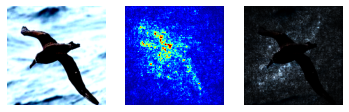

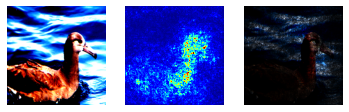

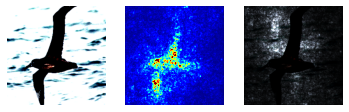

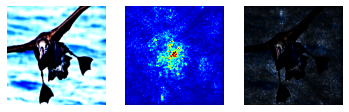

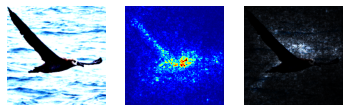

In [8]:
from PIL import Image

resnet18=torch.load('Resnet18_doc_img.pkl')
for i in range(5):
    print("Case: %d"%(i+1))
    ori = test_data[i][0]
    image = TestTrans2(ori)
    image = torch.unsqueeze(image, 0)
    label = torch.tensor(test_datasets[i][1])
    plt.figure()
    plt.subplot(131)
    plt.imshow(image.view(3,224,224).permute(1,2,0).numpy())
    plt.axis('off')
    adv_image = Get_Image_Attention(image, label, resnet18)
    grad_map=np.flipud(adv_image.detach().cpu().view(3,224,224).permute(1,2,0).numpy())
    t_map=np.absolute(grad_map.transpose(2,0,1)[0])+np.absolute(grad_map.transpose(2,0,1)[1])+np.absolute(grad_map.transpose(2,0,1)[2])
    #计算RGB三个通道的导数绝对值之和，作为网络的attention
    plt.subplot(132)
    plt.imshow(t_map, cmap="jet", origin="lower",vmin=0,vmax=(2*t_map.mean()+t_map.max())/3)
    plt.axis('off')
    #对于取值范围做标准化，从而更加明显的显示热点区域
    t_map_nor = (t_map - t_map.min()) / (t_map.max() - t_map.min())*2
    plt.subplot(133)
    img=image.view(3,224,224).permute(1,2,0).numpy()
    #对于取值范围做标准化，乘以图片直观显示注意力的区域
    img[:,:,0]=img[:,:,0]*t_map_nor
    img[:,:,1]=img[:,:,1]*t_map_nor
    img[:,:,2]=img[:,:,2]*t_map_nor
    plt.imshow(img)
    plt.axis('off')
    